In [ ]:

import duckdb 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import joblib

from src.feature_engineering import feature_engineering_lag , feature_engineering_delta ,feature_engineering_ratio,feature_engineering_linreg
from src.random_forests import optim_hiperp , entrenamiento_rf,_imputacion
from src.embedding import distanceMatrix , red_umap 

%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [17]:
data_path = "data/"
data_file = "competencia_01.csv"
df= pd.read_csv(data_path + data_file)

C:\Users\chris\AppData\Local\Temp\ipykernel_27172\4193464990.py:3: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv(data_path + data_file)


#

In [3]:
cat_cols =[]
num_cols=[]
for c in df.columns:
    if (df[c].nunique() <= 5):
        cat_cols.append(c)
    else:
        num_cols.append(c)

In [4]:
cat_cols

['active_quarter',
 'cliente_vip',
 'internet',
 'tcuentas',
 'ccuenta_corriente',
 'cdescubierto_preacordado',
 'ctarjeta_visa',
 'ctarjeta_master',
 'cseguro_vida',
 'cseguro_accidentes_personales',
 'tcallcenter',
 'thomebanking',
 'ccajas_transacciones',
 'tmobile_app',
 'cmobile_app_trx',
 'Master_delinquency',
 'Master_status',
 'Visa_delinquency',
 'Visa_status',
 'clase_ternaria']

In [5]:
lista_t=[c for c in list(map(lambda x : x if x[0]=='t' and x not in cat_cols else np.nan ,df.columns )) if pd.notna(c)]
lista_c=[c for c in list(map(lambda x : x if x[0]=='c' and x not in cat_cols else np.nan ,df.columns )) if pd.notna(c)]
lista_m=[c for c in list(map(lambda x : x if x[0]=='m' and x not in cat_cols else np.nan ,df.columns )) if pd.notna(c)]
lista_r=[c for c in df.columns if c not in (lista_t + lista_c + lista_m + cat_cols)]
print(len(lista_t) , len(lista_c) , len(lista_m) , len(lista_r) , len(cat_cols))
print(len(lista_t) + len(lista_c) + len(lista_m) +len(lista_r) + len(cat_cols))

col_drops=["cliente_edad","numero_de_cliente","cliente_antiguedad"]
cols_transf_previo=lista_m + lista_c+ lista_r
cols_lag_delta = [c for c in cols_transf_previo if c not in col_drops]
cols_lag_delta

0 48 45 42 20
155


['mrentabilidad',
 'mrentabilidad_annual',
 'mcomisiones',
 'mactivos_margen',
 'mpasivos_margen',
 'mcuenta_corriente_adicional',
 'mcuenta_corriente',
 'mcaja_ahorro',
 'mcaja_ahorro_adicional',
 'mcaja_ahorro_dolares',
 'mcuentas_saldo',
 'mautoservicio',
 'mtarjeta_visa_consumo',
 'mtarjeta_master_consumo',
 'mprestamos_personales',
 'mprestamos_prendarios',
 'mprestamos_hipotecarios',
 'mplazo_fijo_dolares',
 'mplazo_fijo_pesos',
 'minversion1_pesos',
 'minversion1_dolares',
 'minversion2',
 'mpayroll',
 'mpayroll2',
 'mcuenta_debitos_automaticos',
 'mttarjeta_visa_debitos_automaticos',
 'mttarjeta_master_debitos_automaticos',
 'mpagodeservicios',
 'mpagomiscuentas',
 'mcajeros_propios_descuentos',
 'mtarjeta_visa_descuentos',
 'mtarjeta_master_descuentos',
 'mcomisiones_mantenimiento',
 'mcomisiones_otras',
 'mforex_buy',
 'mforex_sell',
 'mtransferencias_recibidas',
 'mtransferencias_emitidas',
 'mextraccion_autoservicio',
 'mcheques_depositados',
 'mcheques_emitidos',
 'mcheque

In [6]:
cols_drops=["active_quarter","clase_ternaria"]
lista_regl_max_min = [c for c in cat_cols if c not in  cols_drops] + cols_lag_delta
lista_regl_max_min

['cliente_vip',
 'internet',
 'tcuentas',
 'ccuenta_corriente',
 'cdescubierto_preacordado',
 'ctarjeta_visa',
 'ctarjeta_master',
 'cseguro_vida',
 'cseguro_accidentes_personales',
 'tcallcenter',
 'thomebanking',
 'ccajas_transacciones',
 'tmobile_app',
 'cmobile_app_trx',
 'Master_delinquency',
 'Master_status',
 'Visa_delinquency',
 'Visa_status',
 'mrentabilidad',
 'mrentabilidad_annual',
 'mcomisiones',
 'mactivos_margen',
 'mpasivos_margen',
 'mcuenta_corriente_adicional',
 'mcuenta_corriente',
 'mcaja_ahorro',
 'mcaja_ahorro_adicional',
 'mcaja_ahorro_dolares',
 'mcuentas_saldo',
 'mautoservicio',
 'mtarjeta_visa_consumo',
 'mtarjeta_master_consumo',
 'mprestamos_personales',
 'mprestamos_prendarios',
 'mprestamos_hipotecarios',
 'mplazo_fijo_dolares',
 'mplazo_fijo_pesos',
 'minversion1_pesos',
 'minversion1_dolares',
 'minversion2',
 'mpayroll',
 'mpayroll2',
 'mcuenta_debitos_automaticos',
 'mttarjeta_visa_debitos_automaticos',
 'mttarjeta_master_debitos_automaticos',
 'mpag

In [10]:
df1=feature_engineering_linreg(df,lista_regl_max_min[-4:])


In [15]:
df1.loc[df1["numero_de_cliente"]==930570713, ["numero_de_cliente","foto_mes","Visa_mconsumototal","slope_Visa_mconsumototal"]].sort_values(by="foto_mes")

,numero_de_cliente,foto_mes,Visa_mconsumototal,slope_Visa_mconsumototal
978433,930570713,202101,131952.36,NaN
978434,930570713,202102,122197.01,-9755.350
978435,930570713,202103,60772.82,-35589.770
978436,930570713,202104,53814.41,-29583.804
978437,930570713,202105,84715.53,-11940.285
978438,930570713,202106,91861.97,12416.857


In [6]:
lista_cant=[c for c in list(map(lambda x : x if x[0]=='c' else np.nan ,df.columns )) if pd.notna(c)]
lista_monto = [c for c in list(map(lambda x : x if x[0]=='m' else np.nan ,df.columns )) if pd.notna(c)]
cols_ratios=[]
for c in lista_cant:
    i=0
    while i < len(lista_monto) and c[1:] != lista_monto[i][1:]:
        i+=1
    if i < len(lista_monto):
        cols_ratios.append([lista_monto[i],c ])
cols_ratios

[['mcuenta_corriente', 'ccuenta_corriente'],
 ['mcaja_ahorro', 'ccaja_ahorro'],
 ['mprestamos_personales', 'cprestamos_personales'],
 ['mprestamos_prendarios', 'cprestamos_prendarios'],
 ['mprestamos_hipotecarios', 'cprestamos_hipotecarios'],
 ['minversion2', 'cinversion2'],
 ['mcuenta_debitos_automaticos', 'ccuenta_debitos_automaticos'],
 ['mpagodeservicios', 'cpagodeservicios'],
 ['mpagomiscuentas', 'cpagomiscuentas'],
 ['mcajeros_propios_descuentos', 'ccajeros_propios_descuentos'],
 ['mtarjeta_visa_descuentos', 'ctarjeta_visa_descuentos'],
 ['mtarjeta_master_descuentos', 'ctarjeta_master_descuentos'],
 ['mcomisiones_mantenimiento', 'ccomisiones_mantenimiento'],
 ['mcomisiones_otras', 'ccomisiones_otras'],
 ['mforex_buy', 'cforex_buy'],
 ['mforex_sell', 'cforex_sell'],
 ['mtransferencias_recibidas', 'ctransferencias_recibidas'],
 ['mtransferencias_emitidas', 'ctransferencias_emitidas'],
 ['mextraccion_autoservicio', 'cextraccion_autoservicio'],
 ['mcheques_depositados', 'ccheques_dep

In [11]:
df_1 = feature_engineering_lag(df ,cols_lag_delta , 2)
df_2 = feature_engineering_delta(df_1 ,cols_lag_delta , 2)
df_3= feature_engineering_ratio(df_2 , cols_ratios)
df_3.columns

ejecucion lag finalizada
ejecucion delta finalizada
ejecucion delta finalizada


Index(['numero_de_cliente', 'foto_mes', 'active_quarter', 'cliente_vip',
       'internet', 'cliente_edad', 'cliente_antiguedad', 'mrentabilidad',
       'mrentabilidad_annual', 'mcomisiones',
       ...
       'ratio_mcomisiones_otras_ccomisiones_otras',
       'ratio_mforex_buy_cforex_buy', 'ratio_mforex_sell_cforex_sell',
       'ratio_mtransferencias_recibidas_ctransferencias_recibidas',
       'ratio_mtransferencias_emitidas_ctransferencias_emitidas',
       'ratio_mextraccion_autoservicio_cextraccion_autoservicio',
       'ratio_mcheques_depositados_ccheques_depositados',
       'ratio_mcheques_emitidos_ccheques_emitidos',
       'ratio_mcheques_depositados_rechazados_ccheques_depositados_rechazados',
       'ratio_mcheques_emitidos_rechazados_ccheques_emitidos_rechazados'],
      dtype='object', length=706)

# OPTIMIZACION HIPERPARAMETROS


In [19]:
mes =202104
f = df["foto_mes"] == mes
df = df.loc[f]

X_train=df.drop(columns="clase_ternaria")
y_train = df["clase_ternaria"].copy()

In [20]:
np.unique(y_train)

array(['BAJA+1', 'BAJA+2', 'Continua'], dtype=object)

In [25]:
np.unique(y_train ,return_counts=True)

(array(['BAJA+1', 'BAJA+2', 'Continua'], dtype=object),
 array([   954,   1131, 161333]))

In [26]:
y_conv=y_train.map( lambda x: 0 if x=="Continua" else 1)
np.unique(y_conv ,return_counts=True)

(array([0, 1]), array([161333,   2085]))

In [12]:
np.random.seed(17)
continua_sample = y_train[y_train == "Continua"].sample(2000).index
bajas_1_2 = y_train[y_train != "Continua"].index
rf_index = continua_sample.union(bajas_1_2)

X_train_rf = X_train.loc[rf_index]
y_train_rf = y_train.loc[rf_index]

In [24]:
n_trials=50
study=optim_hiperp(X_train_rf,y_train_rf,n_trials= n_trials)

[I 2025-09-15 13:56:49,343] Using an existing study with name 'exp_206_random-forest-opt' instead of creating a new one.


llegamos aca


[I 2025-09-15 13:56:51,835] Trial 88 finished with value: 827600000.0 and parameters: {'max_depth': 31, 'min_samples_split': 301, 'min_samples_leaf': 2, 'max_features': 0.6894002636775328}. Best is trial 88 with value: 827600000.0.
[I 2025-09-15 13:56:54,137] Trial 89 finished with value: 826080000.0 and parameters: {'max_depth': 32, 'min_samples_split': 321, 'min_samples_leaf': 2, 'max_features': 0.69576841078367}. Best is trial 88 with value: 827600000.0.
[I 2025-09-15 13:56:56,508] Trial 90 finished with value: 827360000.0 and parameters: {'max_depth': 32, 'min_samples_split': 321, 'min_samples_leaf': 2, 'max_features': 0.6977287835601695}. Best is trial 88 with value: 827600000.0.
[I 2025-09-15 13:56:59,084] Trial 91 finished with value: 825260000.0 and parameters: {'max_depth': 32, 'min_samples_split': 309, 'min_samples_leaf': 1, 'max_features': 0.6986030008818512}. Best is trial 88 with value: 827600000.0.
[I 2025-09-15 13:57:01,658] Trial 92 finished with value: 826860000.0 and 

In [25]:
best_params = study.best_params
model = entrenamiento_rf(X_train_rf, y_train_rf,best_params)

In [37]:
import joblib
model=joblib.load("src/outputs/random_forest/model/rf_model_2025-09-15 13_58_18.sav")

In [38]:
print("ya esta")

ya esta


In [39]:
Xtrain_rf_imp=_imputacion(X_train_rf)

Xtrain_rf_imp.shape

(4085, 682)

In [40]:
md = distanceMatrix(model, Xtrain_rf_imp)

In [41]:
model.classes_

array(['BAJA+1', 'BAJA+2', 'Continua'], dtype=object)

In [17]:
y_proba = model.predict_proba(Xtrain_rf_imp)
y_proba

array([[0.46404965, 0.43146197, 0.10448838],
       [0.01038003, 0.0456231 , 0.94399687],
       [0.28404227, 0.3242511 , 0.39170663],
       ...,
       [0.3002038 , 0.65459368, 0.04520252],
       [0.29688405, 0.63797459, 0.06514136],
       [0.14076052, 0.28132652, 0.57791297]], shape=(4085, 3))

c:\Users\chris\Data_science\Ms Data Mining UBA\2do_Cuatrimestre\EyF\competencia\bank-churn-prediction\env_comp1\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\chris\Data_science\Ms Data Mining UBA\2do_Cuatrimestre\EyF\competencia\bank-churn-prediction\env_comp1\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


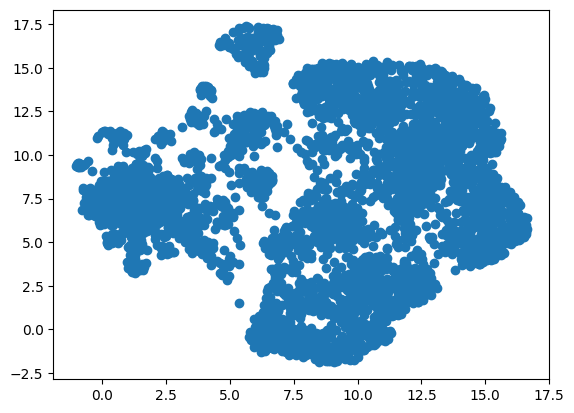

In [18]:
embedding_rf = red_umap(md)
plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

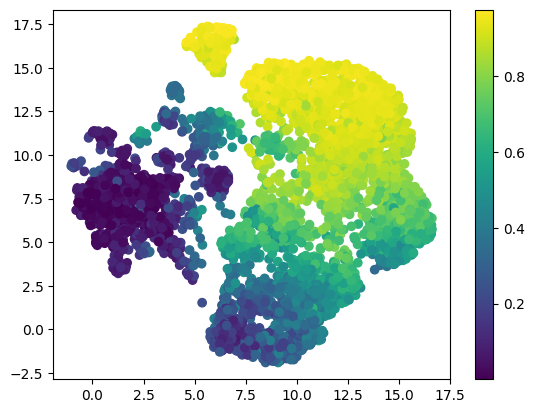

In [19]:
y_proba_baja=y_proba[:,0]+y_proba[:,1]
plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=y_proba_baja)
plt.colorbar()
plt.show()

# Cluster kmeans

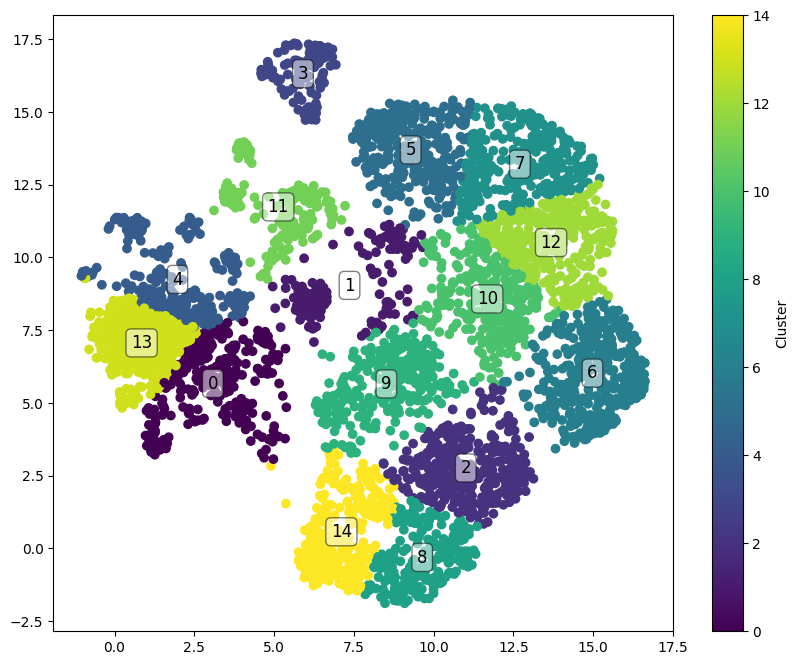

In [20]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=17, n_init=10)
clusters = kmeans.fit_predict(embedding_rf)


plt.figure(figsize=(10, 8))
plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=clusters, cmap='viridis')
plt.colorbar(label='Cluster')

for cluster_label in sorted(np.unique(clusters)):
    cluster_points = embedding_rf[clusters == cluster_label]
    centroid = cluster_points.mean(axis=0)
    plt.text(centroid[0], centroid[1], str(cluster_label), fontsize=12, ha='center', va='center', color='black',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))

plt.show()

In [21]:
cluster_class_df = pd.DataFrame({'cluster': clusters, 'original_class': y_train_rf})
cluster_class_df

,cluster,original_class
179,12,BAJA+2
370,4,Continua
1021,9,Continua
1689,9,Continua
2276,6,Continua
...,...,...
977800,13,Continua
977818,14,BAJA+2
977874,5,BAJA+2
978078,7,BAJA+2


In [22]:
cluster_class_df

,cluster,original_class
179,12,BAJA+2
370,4,Continua
1021,9,Continua
1689,9,Continua
2276,6,Continua
...,...,...
977800,13,Continua
977818,14,BAJA+2
977874,5,BAJA+2
978078,7,BAJA+2


In [23]:
cluster_class_df = pd.DataFrame({'cluster': clusters, 'original_class': y_train_rf})
cluster_class_df["label"]=cluster_class_df["original_class"].map(lambda x: 0 if x=="Continua" else 1)


class_distribution_by_cluster = cluster_class_df.groupby('cluster')['label'].value_counts().unstack(fill_value=0)
cluster_prob_df = pd.DataFrame({'cluster': clusters, 'prob_baja': y_proba_baja.flatten()})
average_prob_baja_by_cluster = cluster_prob_df.groupby('cluster')['prob_baja'].mean()
class_distribution_by_cluster['average_prob_baja'] = average_prob_baja_by_cluster

print("Number of cases per class and average churn probability per cluster:")
print(class_distribution_by_cluster)

Number of cases per class and average churn probability per cluster:
label      0    1  average_prob_baja
cluster                             
0        260   20           0.110324
1         81   66           0.437959
2        143  194           0.526016
3          1  103           0.948662
4        220   21           0.092230
5         16  288           0.937120
6        122  238           0.665364
7         22  291           0.935837
8        168   50           0.325537
9         96  187           0.649792
10        59  241           0.843681
11       117   50           0.354527
12        34  283           0.890694
13       429    4           0.030787
14       232   49           0.236472


In [24]:
important_features_by_cluster = {}
cluster_series_aligned = pd.Series(clusters, index=X_train_rf.index)
for cluster in sorted(np.unique(clusters)):
    print(f"Training model for Cluster {cluster} vs. Rest...")
    y_binary = (cluster_series_aligned == cluster).astype(int)

    model = RandomForestClassifier(n_estimators=100, random_state=17, class_weight='balanced') # Added class_weight for imbalanced data
    model.fit(Xtrain_rf_imp, y_binary)

    importances = model.feature_importances_
    feature_names = X_train_rf.columns

    indices = np.argsort(importances)[::-1]

    important_features_by_cluster[cluster] = [feature_names[i] for i in indices]


Training model for Cluster 0 vs. Rest...
Training model for Cluster 1 vs. Rest...
Training model for Cluster 2 vs. Rest...
Training model for Cluster 3 vs. Rest...
Training model for Cluster 4 vs. Rest...
Training model for Cluster 5 vs. Rest...
Training model for Cluster 6 vs. Rest...
Training model for Cluster 7 vs. Rest...
Training model for Cluster 8 vs. Rest...
Training model for Cluster 9 vs. Rest...
Training model for Cluster 10 vs. Rest...
Training model for Cluster 11 vs. Rest...
Training model for Cluster 12 vs. Rest...
Training model for Cluster 13 vs. Rest...
Training model for Cluster 14 vs. Rest...


In [28]:
X_train_rf.shape

(4085, 682)

In [25]:
print(important_features_by_cluster[7][:10])

['mpasivos_margen', 'ctrx_quarter_lag_1', 'mpasivos_margen_lag_1', 'ctarjeta_visa_transacciones_lag_1', 'mactivos_margen', 'mtarjeta_visa_consumo', 'mtarjeta_visa_consumo_lag_2', 'mpasivos_margen_lag_2', 'ctrx_quarter_lag_2', 'mcuentas_saldo_lag_1']


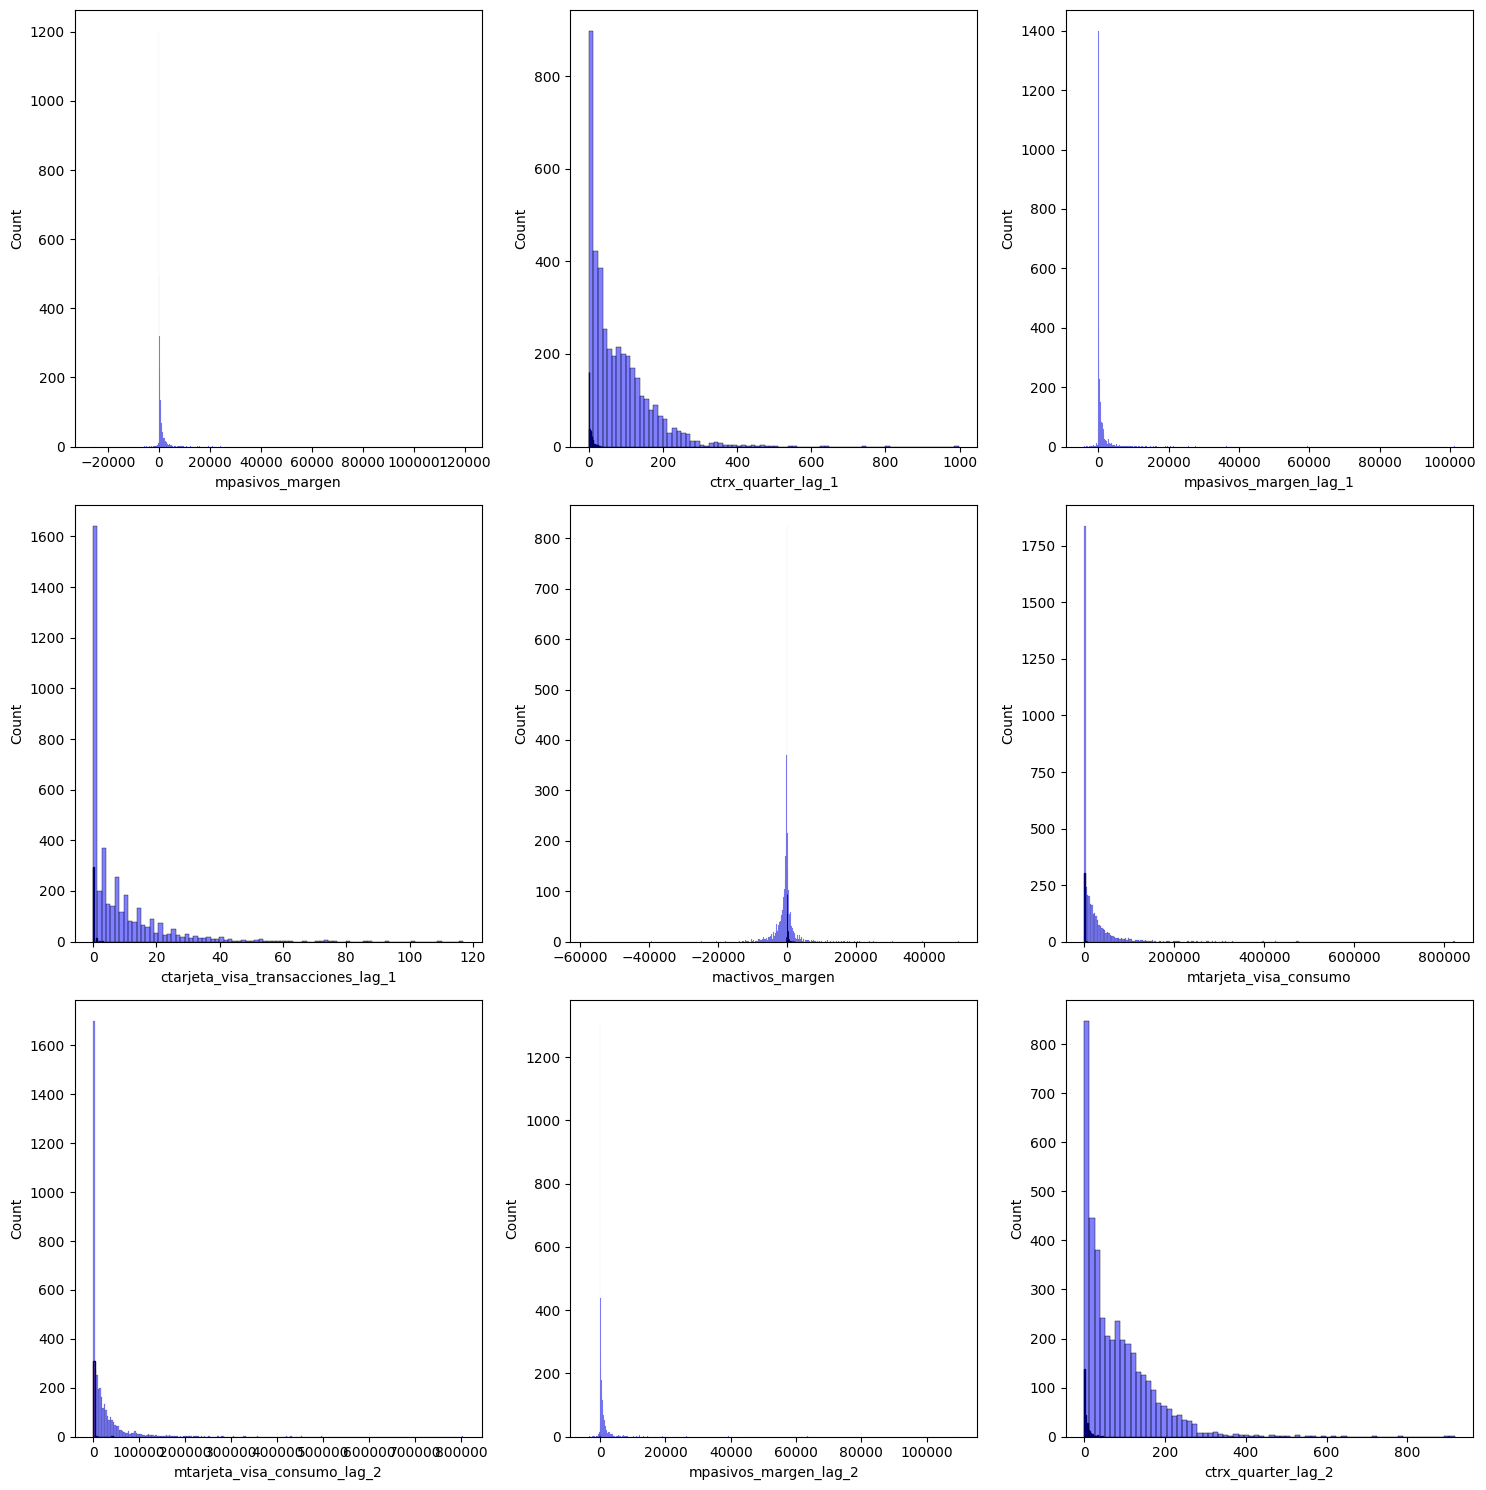

In [26]:
import seaborn as sns
fig,axes=plt.subplots(3,3,figsize=(15,15))
target_cluster=7
axes=axes.flatten()
for i,c in enumerate(important_features_by_cluster[7][:9]):
    ax=axes[i]
    cluster_series_aligned = pd.DataFrame(clusters,columns=["cluster"], index=X_train_rf.index)
    variable_data = X_train_rf[[c]]
    target_cluster_indices = cluster_series_aligned[cluster_series_aligned["cluster"] == target_cluster].index
    target_cluster_data = variable_data.loc[target_cluster_indices]

    rest_indices = cluster_series_aligned[cluster_series_aligned != target_cluster].index
    rest_data = variable_data.loc[rest_indices]

    sns.histplot(data=target_cluster_data,x=c ,color="red",alpha=0.5,ax=ax)
    sns.histplot(data=rest_data,x=c,color="blue",alpha=0.5 ,ax=ax)

plt.tight_layout()
plt.show()




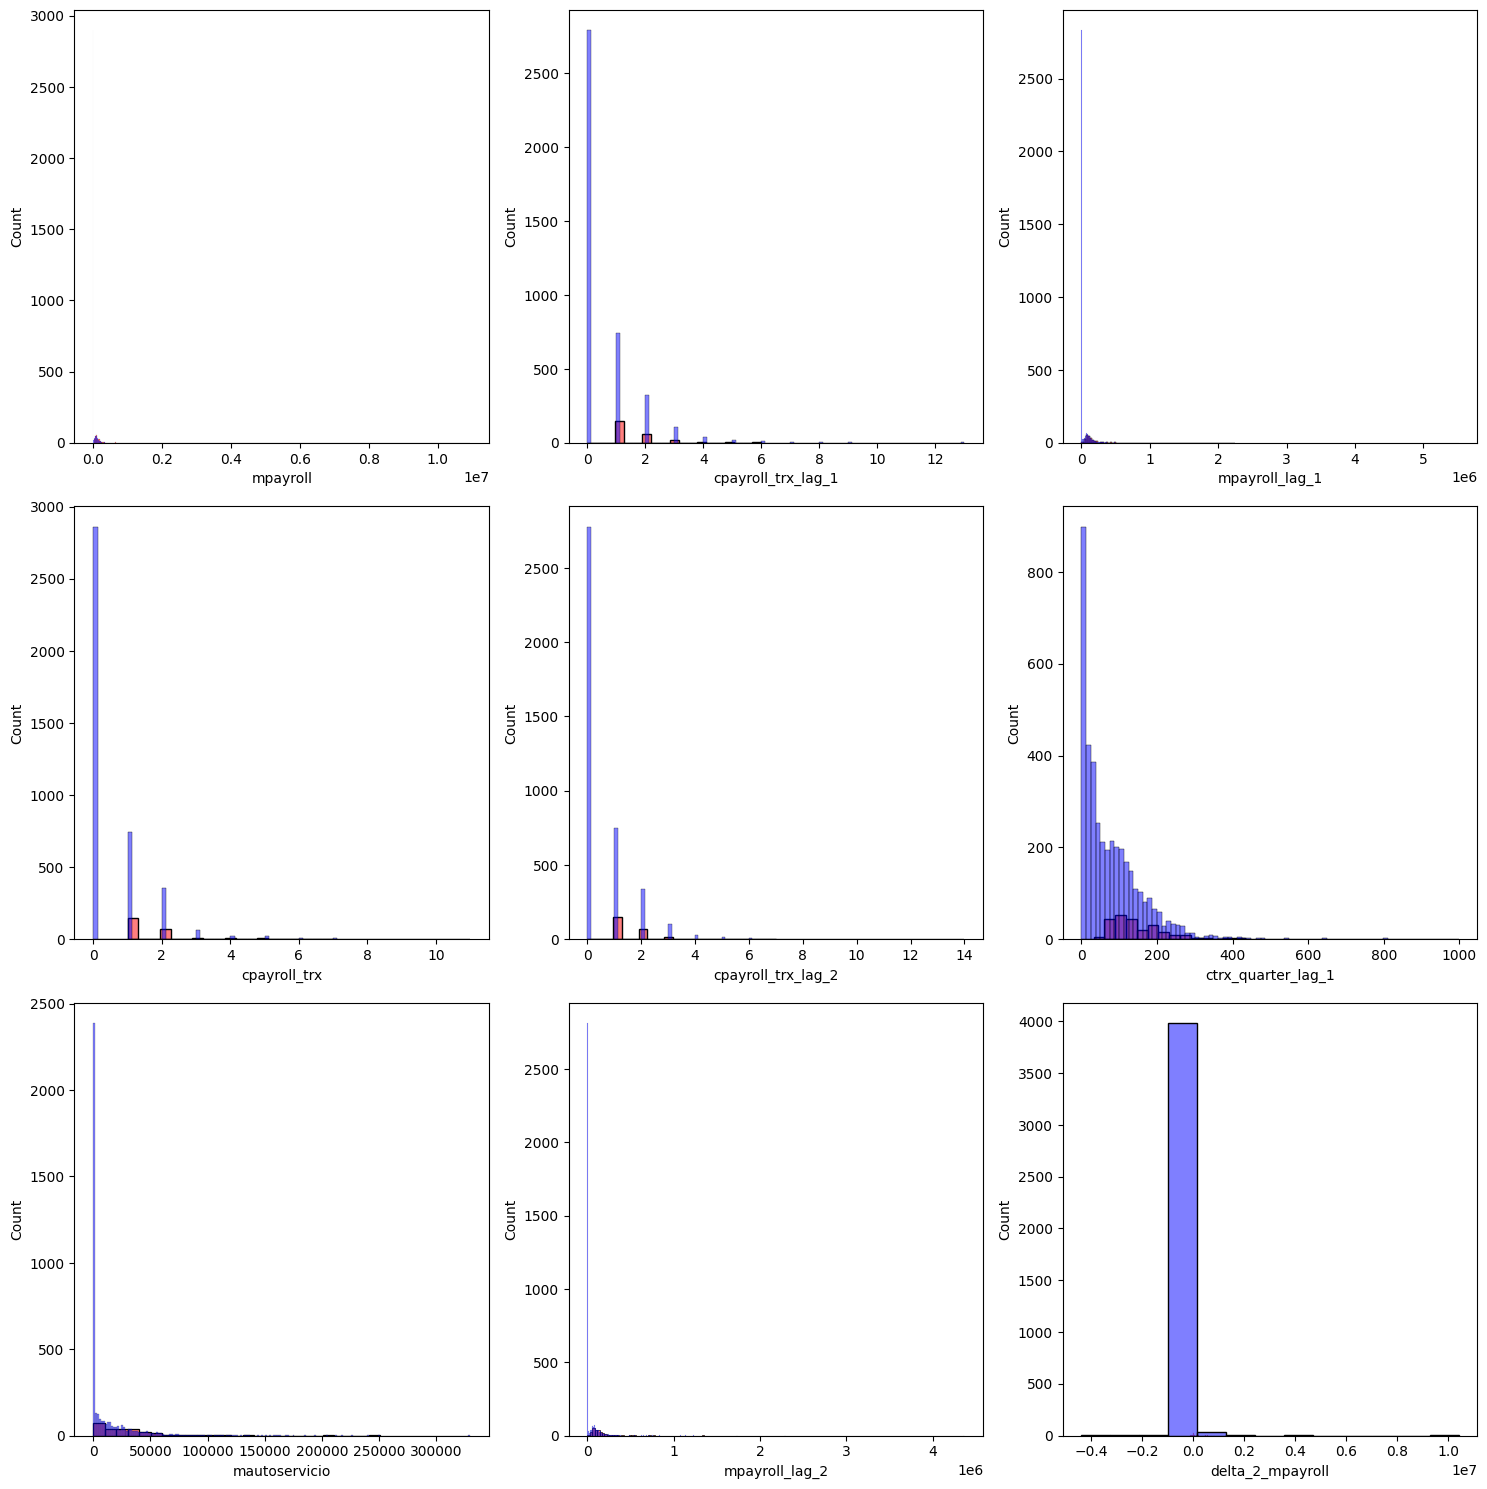

In [27]:
import seaborn as sns
fig,axes=plt.subplots(3,3,figsize=(15,15))
target_cluster=4
axes=axes.flatten()
for i,c in enumerate(important_features_by_cluster[4][:9]):
    ax=axes[i]
    cluster_series_aligned = pd.DataFrame(clusters,columns=["cluster"], index=X_train_rf.index)
    variable_data = X_train_rf[[c]]
    target_cluster_indices = cluster_series_aligned[cluster_series_aligned["cluster"] == target_cluster].index
    target_cluster_data = variable_data.loc[target_cluster_indices]

    rest_indices = cluster_series_aligned[cluster_series_aligned != target_cluster].index
    rest_data = variable_data.loc[rest_indices]

    sns.histplot(data=target_cluster_data,x=c ,color="red",alpha=0.5,ax=ax)
    sns.histplot(data=rest_data,x=c,color="blue",alpha=0.5 ,ax=ax)

plt.tight_layout()
plt.show()




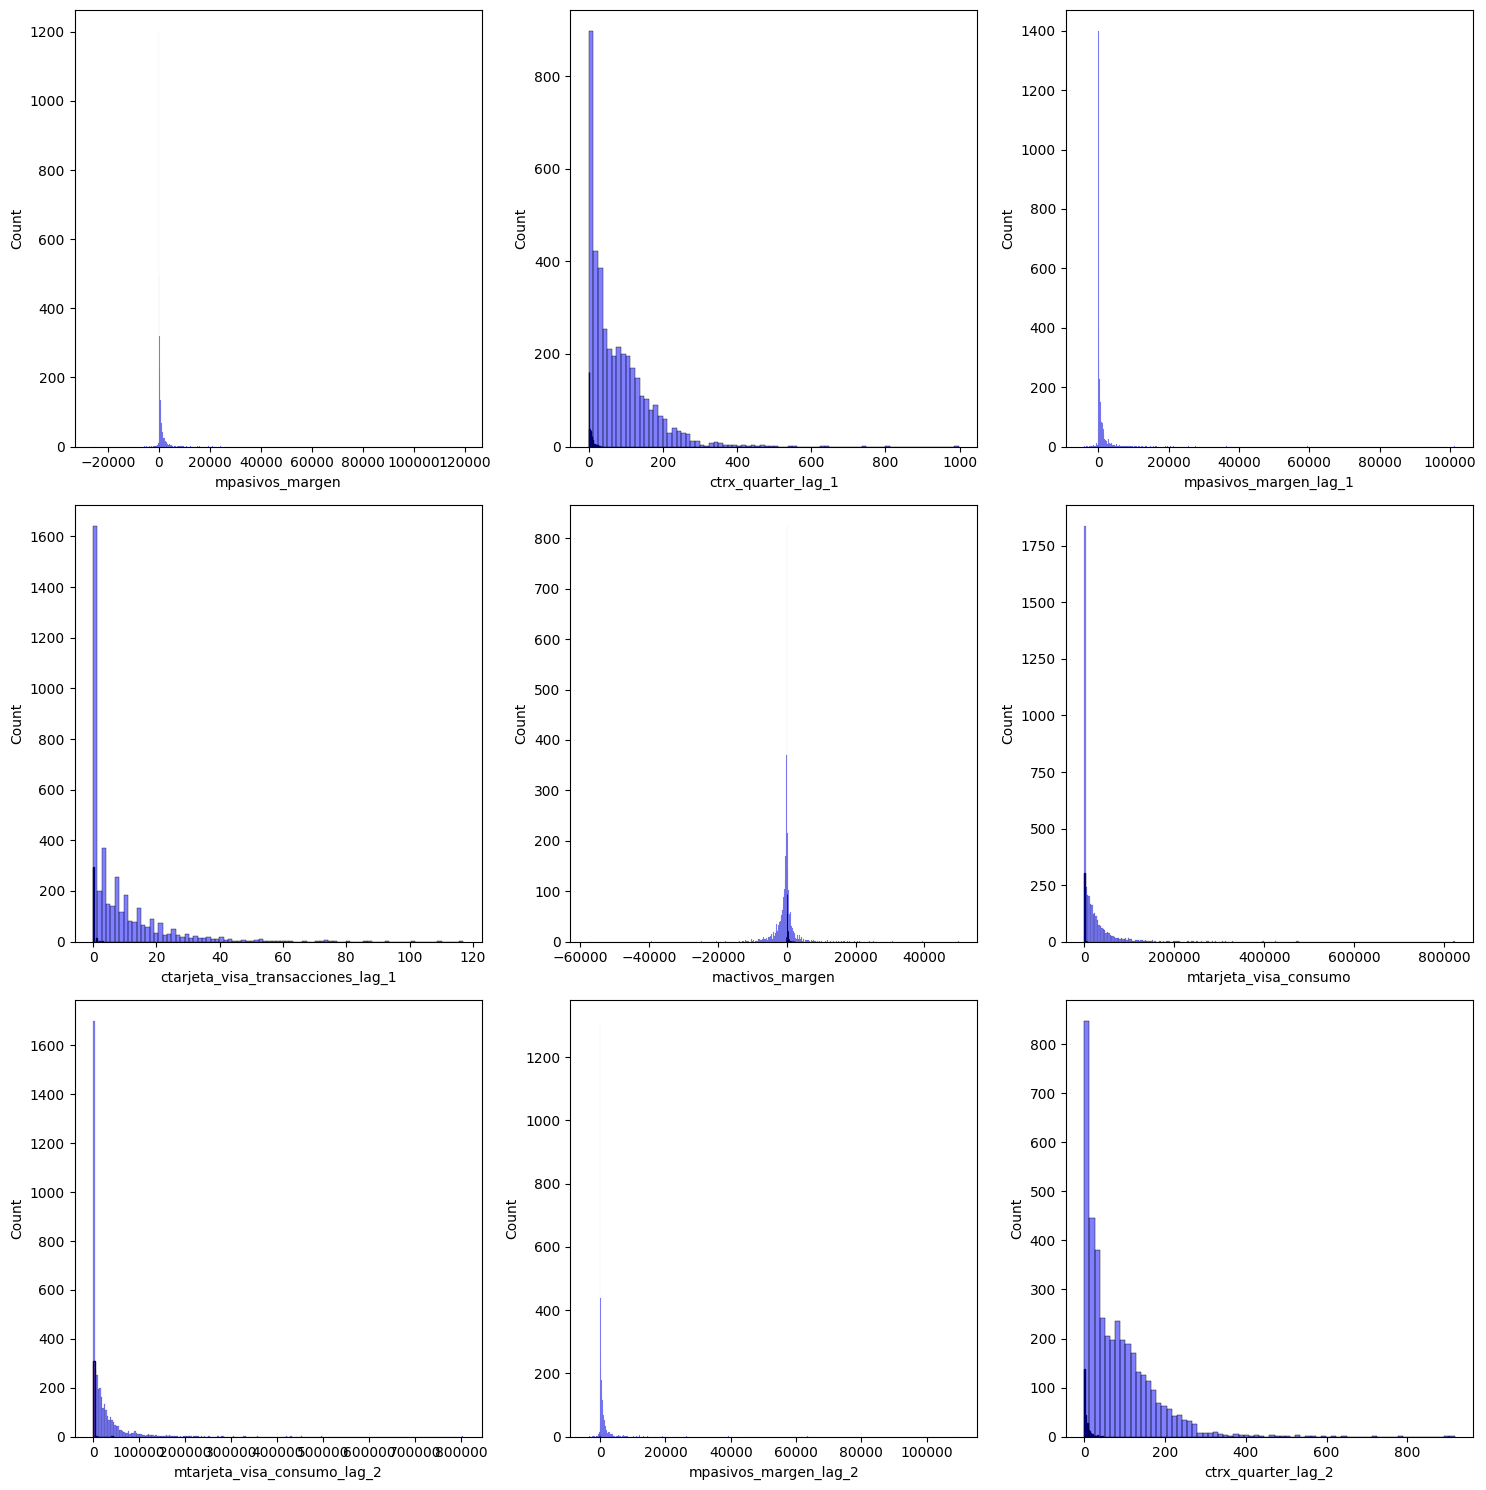

In [30]:
import seaborn as sns
fig,axes=plt.subplots(3,3,figsize=(15,15))
target_cluster=7
target_versus=4
axes=axes.flatten()
for i,c in enumerate(important_features_by_cluster[7][:9]):
    ax=axes[i]
    cluster_series_aligned = pd.DataFrame(clusters,columns=["cluster"], index=X_train_rf.index)
    variable_data = X_train_rf[[c]]
    target_cluster_indices = cluster_series_aligned[cluster_series_aligned["cluster"] == target_cluster].index
    target_cluster_data = variable_data.loc[target_cluster_indices]

    rest_indices = cluster_series_aligned[cluster_series_aligned == target_versus].index
    rest_data = variable_data.loc[rest_indices]

    sns.histplot(data=target_cluster_data,x=c ,color="r",alpha=0.5,ax=ax)
    sns.histplot(data=rest_data,x=c,color="b",alpha=0.5 ,ax=ax)

plt.tight_layout()
plt.show()


In [36]:
def compare_cluster_stats(data, clusters, variable_name, target_cluster):
    

    cluster_series_aligned = pd.Series(clusters, index=data.index)

    variable_data = data[variable_name]

    target_cluster_indices = cluster_series_aligned[cluster_series_aligned == target_cluster].index
    target_cluster_data = variable_data.loc[target_cluster_indices] # Keep NaNs for counting

    rest_indices = cluster_series_aligned[cluster_series_aligned != target_cluster].index
    rest_data = variable_data.loc[rest_indices] # Keep NaNs for counting

    target_cluster_desc = target_cluster_data.dropna().describe()
    rest_desc = rest_data.dropna().describe()

    summary_df = pd.DataFrame({
        f'Cluster {target_cluster}': target_cluster_desc,
        f'Rest of Clusters': rest_desc
    })

    summary_df.loc['unique'] = [target_cluster_data.nunique(), rest_data.nunique()]
    summary_df.loc['missing'] = [target_cluster_data.isnull().sum(), rest_data.isnull().sum()]

    return summary_df

# print(f"'mcaja_ahorro' - Cluster 0 vs. Rest")
# compare_cluster_stats(Xtrain_rf, clusters, 'mcaja_ahorro', 0)

summary_cluster7={}
for c in important_features_by_cluster[7][:10]:
    print("*************************************************************************")
    print(c)
    summary_cluster7[c]=compare_cluster_stats(X_train_rf, clusters, c, 7)
    print(summary_cluster7[c])



*************************************************************************
mpasivos_margen


ValueError: Length of values (16) does not match length of index (4085)

In [59]:
summary_cluster4={}
for c in important_features_by_cluster[4][:10]:
    print("*************************************************************************")
    print(c)
    summary_cluster4[c]=compare_cluster_stats(X_train_rf, clusters, c, 4)
    print(summary_cluster4[c])

*************************************************************************
cpayroll_trx_lag_1
         Cluster 4  Rest of Clusters
count        556.0            3504.0
mean      1.541367           0.36016
std       0.910448           1.21855
min            0.0               0.0
25%            1.0               0.0
50%            1.0               0.0
75%            2.0               0.0
max            9.0              42.0
unique         8.0              13.0
missing        0.0              25.0
*************************************************************************
mpayroll
            Cluster 4  Rest of Clusters
count    5.560000e+02      3.529000e+03
mean     1.754436e+05      1.707301e+04
std      1.904062e+05      5.251666e+04
min      3.166334e+04      0.000000e+00
25%      8.706015e+04      0.000000e+00
50%      1.291859e+05      0.000000e+00
75%      1.894860e+05      0.000000e+00
max      2.096284e+06      1.148335e+06
unique   5.540000e+02      6.130000e+02
missing  0.000000

In [34]:
for i in range(15):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [35]:
clusters = range(16)
summary_cluster_todos={}
for k in clusters:
    summary_cluster_todos[k]={}
    for c in important_features_by_cluster[k][:10]:
        print("*************************************************************************")
        print(c)
        summary_cluster_todos[k][c]=compare_cluster_stats(X_train_rf, clusters, c, k)
        print(summary_cluster_todos[k][c])

*************************************************************************
cpayroll_trx


NameError: name 'compare_cluster_stats' is not defined

In [56]:
summary_cluster7.keys()

dict_keys(['ctarjeta_visa', 'mcuentas_saldo_lag_1', 'mcuenta_corriente', 'mcuenta_corriente_lag_1', 'mcaja_ahorro', 'ctarjeta_visa_transacciones_lag_1', 'mcaja_ahorro_lag_2', 'ctrx_quarter_lag_1', 'cproductos_lag_2', 'cproductos'])

--------------------------

In [14]:
n_trials=25
study=optim_hiperp(X_train,y_train,n_trials= n_trials)

[I 2025-09-14 15:04:59,880] Using an existing study with name 'exp_206_random-forest-opt' instead of creating a new one.


llegamos aca


[I 2025-09-14 15:07:07,284] Trial 10 finished with value: 343640000.0 and parameters: {'max_depth': 22, 'min_samples_split': 261, 'min_samples_leaf': 94, 'max_features': 0.2299885083191261}. Best is trial 10 with value: 343640000.0.
[I 2025-09-14 15:12:09,309] Trial 11 finished with value: 303960000.0 and parameters: {'max_depth': 20, 'min_samples_split': 1908, 'min_samples_leaf': 186, 'max_features': 0.5538808046995977}. Best is trial 10 with value: 343640000.0.
[I 2025-09-14 15:13:15,334] Trial 12 finished with value: 331420000.0 and parameters: {'max_depth': 11, 'min_samples_split': 43, 'min_samples_leaf': 99, 'max_features': 0.07087914882724963}. Best is trial 10 with value: 343640000.0.
[I 2025-09-14 15:14:04,424] Trial 13 finished with value: 326000000.0 and parameters: {'max_depth': 11, 'min_samples_split': 133, 'min_samples_leaf': 98, 'max_features': 0.07073947501806671}. Best is trial 10 with value: 343640000.0.
[I 2025-09-14 15:14:44,944] Trial 14 finished with value: 3267200

In [15]:
study.best_params

{'max_depth': 31,
 'min_samples_split': 235,
 'min_samples_leaf': 89,
 'max_features': 0.2688398569656583}

In [16]:
study.best_trial.params

{'max_depth': 31,
 'min_samples_split': 235,
 'min_samples_leaf': 89,
 'max_features': 0.2688398569656583}

In [ ]:
import json

best_params = study.best_trial.params

with open("src/outputs/random_forest/model/best_params.json", "w") as f:
    json.dump(best_params, f, indent=4)  # indent=4 para que quede legible

In [9]:
import json
with open("src/outputs/random_forest/model/best_params.json", "r") as f:
    best_params = json.load(f)
print(best_params)

{'max_depth': 31, 'min_samples_split': 235, 'min_samples_leaf': 89, 'max_features': 0.2688398569656583}


In [ ]:
# best_params = study.best_params
model = entrenamiento_rf(X_train, y_train,best_params)

In [ ]:
# import joblib
# model=joblib.load("src/outputs/random_forest/model/exp_206_random_forest_model_100.sav")

In [10]:
Xtrain_rf_imp=_imputacion(X_train)
Xtrain_rf_imp.head()

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,delta_1_Visa_fechaalta,delta_2_Visa_fechaalta,delta_1_Visa_mconsumototal,delta_2_Visa_mconsumototal,delta_1_Visa_cconsumos,delta_2_Visa_cconsumos,delta_1_Visa_cadelantosefectivo,delta_2_Visa_cadelantosefectivo,delta_1_Visa_mpagominimo,delta_2_Visa_mpagominimo
3,302071279.0,202104.0,1.0,0.0,0.0,48.0,376.0,1030.32,31535.20,1322.56,...,30.0,61.0,3212.05,-2058.41,1.0,0.0,0.0,0.0,175.95,-105.57
9,302089801.0,202104.0,1.0,0.0,0.0,61.0,280.0,2056.29,20175.41,529.01,...,30.0,61.0,0.00,-385.91,0.0,-1.0,0.0,0.0,-58.65,117.30
15,302105993.0,202104.0,1.0,0.0,0.0,62.0,323.0,9882.24,118366.76,4066.80,...,30.0,61.0,-3023.14,-2691.46,-2.0,-4.0,0.0,0.0,-1114.35,-1419.33
21,302191168.0,202104.0,1.0,0.0,0.0,74.0,323.0,1027.63,2323.14,1654.22,...,30.0,61.0,3167.35,351.66,-5.0,-10.0,0.0,0.0,234.60,-117.30
27,302202987.0,202104.0,1.0,0.0,0.0,58.0,7.0,-1205.57,1240.97,814.66,...,30.0,61.0,2705.45,-10187.71,0.0,-2.0,0.0,0.0,-1184.73,-1536.63


# REDUCCION DE DIMENSIONALIDAD

In [13]:
X_train.shape

(163418, 682)

In [12]:
model=joblib.load("src/outputs/random_forest/model/exp_206_random_forest_model_100.sav")
md = distanceMatrix(model, Xtrain_rf_imp)
md

MemoryError: Unable to allocate 199. GiB for an array with shape (163418, 163418) and data type int64

In [ ]:
X_train.shape

NameError: name 'distanceMatrix' is not defined